# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance[" Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [12]:
import json

# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(filename, 'r') as f:
      result = f.read()
  return float(result)

In [13]:
import mip
import math
import numpy as np

def fast_distance_matrix(x):
    x = np.array(x)
    #
    # Inspired by: 
    # https://github.com/eth-cscs/PythonHPC/blob/master/numpy/03-euclidean-distance-matrix-numpy.ipynb
    #
    # The "Euclidean Trick" math: 
    # https://www.robots.ox.ac.uk/~albanie/notes/Euclidean_distance_trick.pdf
    #
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

def solve(inst):
  farms = range(inst["n"])        # number of farms
  plants = range(inst["p"])       # number of plants
  corn_chopping = inst["c"]       # vector of corn chopping production for each farm
  dry_matter = inst["a"]          # vector dry matter percentage per each farm
  farm_location = inst["points"]  # vector of farm locations (x,y)
  plant_efficency = inst["Q"]     # quantity of biogas produced per each plant per each ton of corn chopped
  energy_value = inst["b"]        # energy value of biogas (€/kWh)
  max_energy = inst["M"]          # energy limit for the whole system (kWh)
  min_dry_matter = inst["kmin"]
  max_dry_matter = inst["kmax"]

  m = mip.Model(name="biogas-plant-location", sense=mip.MAXIMIZE)
  
  ## Variables ##
  # x[i][j] = 1 if plant j is build in farm i
  x = [[m.add_var(var_type=mip.BINARY) for j in plants] for i in farms]

  # y[i][j] = 1 if farm i is connected to plant j
  y = [[m.add_var(var_type=mip.BINARY) for j in plants] for i in farms]

  # sold fuel from farm i to plant j
  sold_fuel = [[m.add_var() for j in plants] for i in farms]


  ## Constraints ##
  
  '''
  @vector of size p
  1 if plant i is built in any location
  0 otherwise
  '''
  is_plant_build = [mip.xsum(x[i][j] for i in farms) for j in plants]

  # each plant is connected to exactly one farm
  for i in plants:
    m += is_plant_build[i] == 1

  '''
  @vector
  listing the number of plants build in each farm
  '''
  plants_in_farm = [mip.xsum(x[j][i] for i in plants) for j in farms]

  # each farm has at most one plant
  for i in farms:
    m += plants_in_farm[i] <= 1

  '''
  @vector of len n
  1 if the farm is connnected to a plant
  0 otherwise
  '''
  farm_connections = [mip.xsum(y[i][j] for j in plants) for i in farms]

  # each farm sell to at most one plant
  for i in plants:
    m += farm_connections[i] <= 1

  # if y_ij = 1 then x_kj = 1 for any k in plants
  for i in farms:
    for j in plants:
      m += y[i][j] <= mip.xsum(x[j][k] for k in plants)
  
  # fuel can be sold only from connected farms
  for i in farms:
    for j in plants:
      m += sold_fuel[i][j] <= y[i][j] * corn_chopping[i]

  # fuel constraints
  bought_fuel = [mip.xsum(sold_fuel[i][j] for i in farms) for j in plants] 
  dry_matter_in_bought_fuel = [mip.xsum(sold_fuel[i][j] * dry_matter[i] for i in farms) for j in plants]
  
  for i in plants:
    m += dry_matter_in_bought_fuel[i] >= min_dry_matter * bought_fuel[i]
    m += dry_matter_in_bought_fuel[i] <= max_dry_matter * bought_fuel[i]

  # energy production cannot exceed limit
  for i in plants:
    m += bought_fuel[i] * plant_efficency <= max_energy
      

  ## Objective function ##

  # sold energy!
  earnings = mip.xsum(bought_fuel[i] * plant_efficency * energy_value for i in plants)
  
  '''
  a quanto pare inutile:
  # cost of transportation from farm i to plant j
  '''
  distance = fast_distance_matrix(farm_location)
  '''
  transp_cost = mip.xsum( distance[i][j] * y[i][j]
                          for i in range(j, len(farms)) for j in farms)
  '''
  m.objective = mip.maximize(earnings)

  ## Optimization ##

  m.verbose = 0
  m.emphasis = 1 # FEASIBLE
  m.max_seconds = 600
  %timeit m.optimize(max_seconds=600)

  ## Output ##

  print("\nOptimization status: {}".format(m.status))
  print("Optimal solution: {}".format(m.objective_value))
  
  # compute the transportation cost between the farms and the plants
  transp_cost = 0
  for i in farms:
    for j in plants:
      if(y[i][j].x == 1):
        transp_cost += distance[i][j]
  
  print("Transportation cost: {}".format(transp_cost))
  print("Real opt sol:{}".format(m.objective_value - transp_cost))
  
  #plot the plants & farms
  plant_location = []
  for i in farms:
    for j in plants:
      if (x[i][j].x == 1):
        plant_location.append(farm_location[j])
        break
  
  import matplotlib.pyplot as plt
  plt.scatter([x[0] for x in farm_location], [x[1] for x in farm_location], color='blue')
  plt.scatter([x[0] for x in plant_location], [x[1] for x in plant_location], color='red')
  
  plt.xlim(0, 100)
  plt.show()

  return m.objective_value #- transp_cost

In [14]:
def test(n):
    inst = load_instance('instances/instance_'+str(n)+'.json')
    res = load_result("results/instance_"+str(n)+".txt")
    obj = solve(inst)
    print(res)

    print("goodness: " + str((obj - res) * 100 / res) + " %")

 LP relaxation is infeasible or too expensive
Cbc0045I Solution of 2.1945e+07 already found by heuristic
Cbc0045I MIPStart provided solution with cost 2.1945e+07
Cbc0012I Integer solution of 21945035 found by Reduced search after 0 iterations and 0 nodes (12.04 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 2.1945e+07 already found by heuristic
Cbc0038I Initial state - 5 integers unsatisfied sum - 2.10208
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.54169e+06 iterations 9
Cbc0038I Solution found of 1.54169e+06
Cbc0038I Relaxing continuous gives 1.61686e+06
Cbc0038I Before mini branch and bound, 15 integers at bound fixed and 3 continuous
Cbc0038I Full problem 33 rows 30 columns, reduced to 6 rows 8 columns
Cbc0038I Mini branch and bound improved solution from 1.61686e+06 to 1.69151e+06 (0.01 seconds)
Cbc0038I Round again with cutoff of 1.69596e+06
Cbc0038I Reduced cost fixing fixed 4 variables on major pass 2
Cbc0038I Pass   2: suminf.    0.

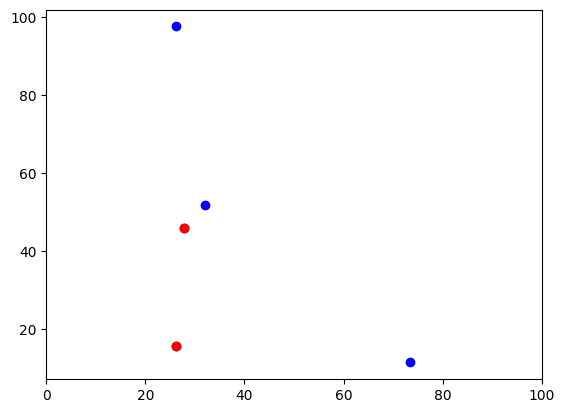

1324477.6736137536
goodness: 27.71126616271711 %
I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 3 (Clique) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 4 (OddWheel) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 5 (MixedIntegerRounding2) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 6 (FlowCover) - 3 row cuts average 4.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is 1
Cbc0014I Cut generator 7 (TwoMirCuts) - 11 row cuts average 10.5 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is 1
Cbc0001I Search completed - best objective 1691507.207014624, took 17 iterations and 0 nodes (0.02 seconds)
Cbc0035I Max

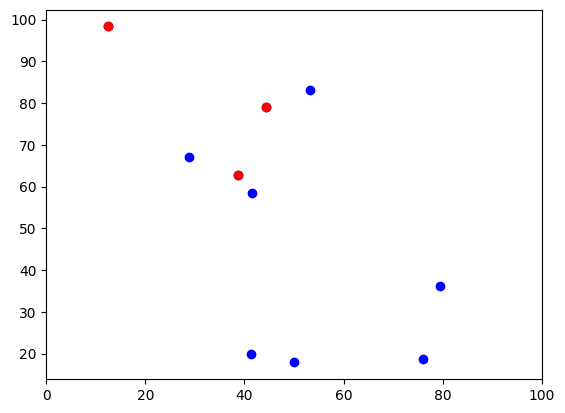

385611.91779212654
goodness: 80.95314120200877 %
ions and 0 nodes (0.00 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 697777 already found by heuristic
Cbc0038I Initial state - 12 integers unsatisfied sum - 2.09649
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 3.66466e+06 iterations 74
Cbc0038I Solution found of 3.66466e+06
Cbc0038I Relaxing continuous gives 3.7427e+06
Cbc0038I Before mini branch and bound, 228 integers at bound fixed and 108 continuous
Cbc0038I Full problem 290 rows 360 columns, reduced to 12 rows 12 columns
Cbc0038I Mini branch and bound improved solution from 3.7427e+06 to 3.89312e+06 (0.01 seconds)
Cbc0038I Freeing continuous variables gives a solution of 3.89312e+06
Cbc0038I After 0.01 seconds - Feasibility pump exiting with objective of 3.89312e+06 - took 0.01 seconds
Cbc0012I Integer solution of 3893124.1 found by feasibility pump after 0 iterations and 0 nodes (0.01 seconds)
Cbc0001I Search completed - best objective 3

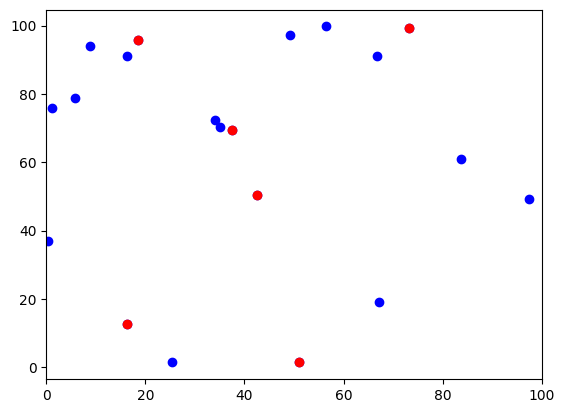

2357066.9429236925
goodness: 65.16816125426962 %
 provided solution with cost 3.89312e+06
Cbc0012I Integer solution of 3893124.1 found by Reduced search after 0 iterations and 0 nodes (0.01 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 3.89312e+06 already found by heuristic
Cbc0045I MIPStart provided solution with cost 3.89312e+06
Cbc0012I Integer solution of 3893124.1 found by Reduced search after 0 iterations and 0 nodes (0.01 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 3.89312e+06 already found by heuristic
Cbc0045I MIPStart provided solution with cost 3.89312e+06
Cbc0012I Integer solution of 3893124.1 found by Reduced search after 0 iterations and 0 nodes (0.01 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 3.89312e+06 already found by heuristic
Cbc0045I MIPStart provided solution with cost 3.89312e+06
Cbc0012I Integer solution of 3893124.1 found by Reduced

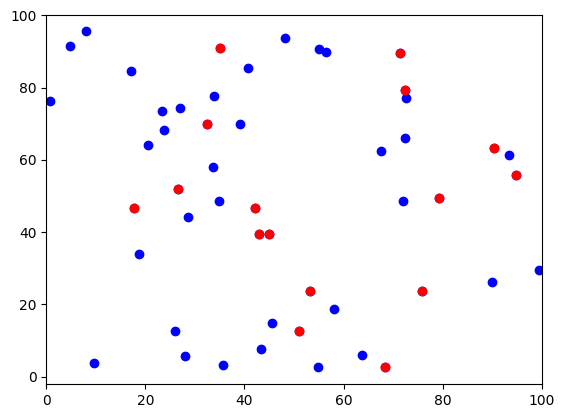

9414476.549923249
goodness: 53.61711516863805 %


In [15]:
test(1)
test(2)
test(3)
test(4)

200 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 6852048.528558768
Transportation cost: 3630.5968349145664
Real opt sol:6848417.931723854


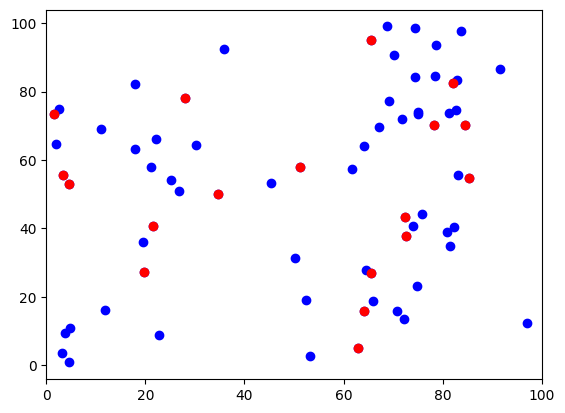

6852048.528558768

In [16]:
n = 5
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

475 ms ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 8237473.9952830905
Transportation cost: 3298.7385625215716
Real opt sol:8234175.256720569


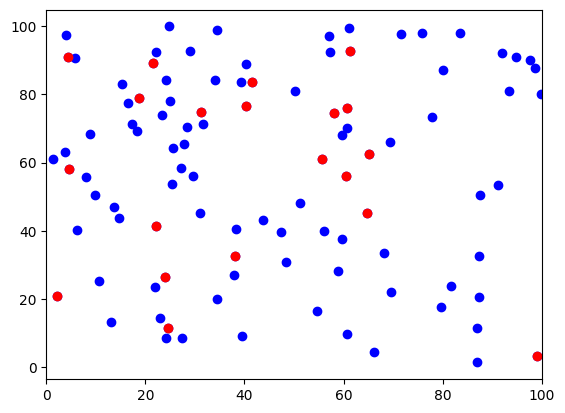

8237473.9952830905

In [17]:
n = 6
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

 of 14462247 found by Reduced search after 0 iterations and 0 nodes (0.10 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 1.44622e+07 already found by heuristic
Cbc0045I MIPStart provided solution with cost 1.44622e+07
Cbc0012I Integer solution of 14462247 found by Reduced search after 0 iterations and 0 nodes (0.10 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 1.44622e+07 already found by heuristic
Cbc0045I MIPStart provided solution with cost 1.44622e+07
Cbc0012I Integer solution of 14462247 found by Reduced search after 0 iterations and 0 nodes (0.09 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 1.44622e+07 already found by heuristic
Cbc0045I MIPStart provided solution with cost 1.44622e+07
Cbc0012I Integer solution of 14462247 found by Reduced search after 0 iterations and 0 nodes (0.11 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045

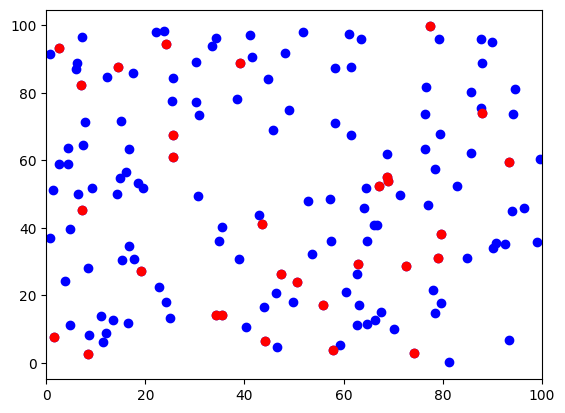

19601360.87143771

In [18]:
n = 7
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

4.69 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 25770360.471936706
Transportation cost: 6931.613564646648
Real opt sol:25763428.85837206


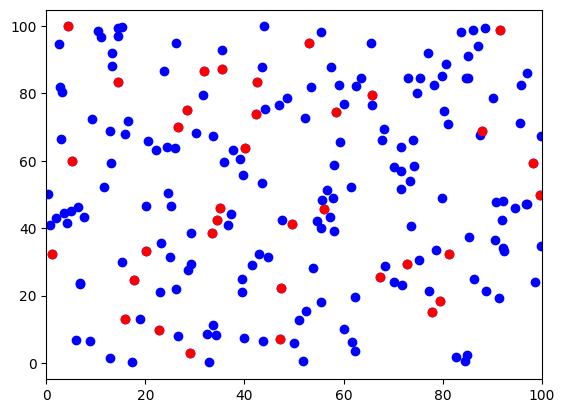

25770360.471936706

In [19]:
n = 8
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

9.66 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 15957095.096229332
Transportation cost: 8402.268832327201
Real opt sol:15948692.827397004


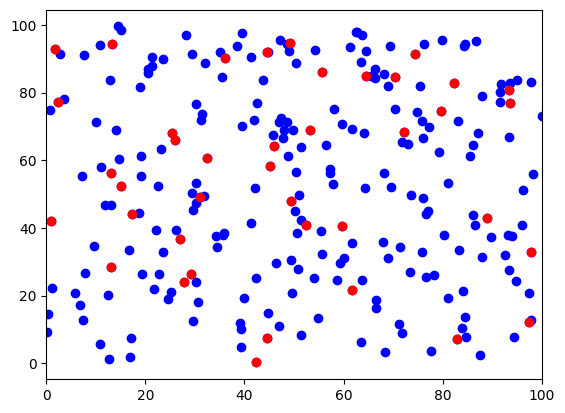

15957095.096229332

In [20]:
n = 9
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

20.6 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 21945034.77510881
Transportation cost: 11452.70926217733
Real opt sol:21933582.065846633


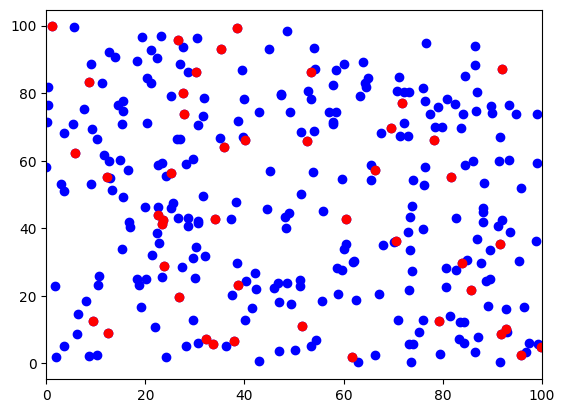

21945034.77510881

In [21]:
n = 10
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)